# PV3 Database access and data visualisations - WR

<img src="http://reiner-lemoine-institut.de//wp-content/uploads/2015/09/rlilogo.png" width="100" style="float: right">

__copyright__ 	= "© Reiner Lemoine Institut" <br>
__license__ 	= "GNU Affero General Public License Version 3 (AGPL-3.0)" <br>
__url__ 		= "https://www.gnu.org/licenses/agpl-3.0.en.html" <br>
__author__ 		= "Ludwig Hülk" <br>
__editor__      = "Kilian Helfenbein" <br>

# Imports

In [1]:
import sys
import os
import getpass
import pandas as pd
import numpy as np
import json
from sqlalchemy import *
# plot
import matplotlib.pyplot as plt
import subprocess, os
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib import rcParams
from scipy.interpolate import interpn
import plotly.graph_objs as go
import plotly.offline as pltly
import colorlover as cl
import seaborn as sns
# notebook
from IPython.display import Image
from IPython.core.display import HTML 
from scipy.stats import gaussian_kde

pltly.init_notebook_mode(connected=True)
%matplotlib inline

rcParams['font.family'] = 'Verdana'

version = 'v1 (jupyter)'
project = 'pv3'

# Database Connection

In [2]:
def postgres_session():
    """SQLAlchemy session object with valid connection to reeem database"""
    
    print('Please provide connection parameters to database:\n' +
              'Hit [Enter] to take defaults')
    host = 'localhost' # input('host (default 130.226.55.43): ')
    port = '5432' # input('port (default 5432): ')
    database = 'sonnja_db' # input("database name (default 'reeem'): ")
    user = 'sonnja' # input('user (default postgres): ')
    # password = input('password: ')
    password = getpass.getpass(prompt='password: ',
                                   stream=sys.stderr)
    con = create_engine(
            'postgresql://' + '%s:%s@%s:%s/%s' % (user,
                                                  password,
                                                  host,
                                                  port,
                                                  database)).connect()
    print('Password correct! Database connection established.')
    return con

# start session
con = postgres_session()

C:\Anaconda3\envs\d_py37_vis\lib\site-packages\ipykernel_launcher.py:12: UserWarning:

The `stream` parameter of `getpass.getpass` will have no effect when using ipykernel



Please provide connection parameters to database:
Hit [Enter] to take defaults
password: ········
Password correct! Database connection established.


# Data Analysis

## Select table metadata

This section can be used to get the metadata from one database table.<br>
The result is printed.<br>

In [3]:
# Database select (SQL)
sql = text("""SELECT obj_description('pv3.einleuchtend_wrdata_2015_wr1'::regclass);""")
meta_str = pd.read_sql_query(sql, con).loc[0, 'obj_description']
print(meta_str)

{
    "name": "einleuchtend_wrdata_2015_wr1",
    "title": "SonnJa! einleuchtend e.V. WR 1 data 2015",
    "id": null,
    "description": "Data of the measurement series of inverter 1 of the experimental PV system of einleuchtend e.V. at the HTW Berlin",
    "language": [
        "en-GB",
		"de-DE"
    ],
    "keywords": [
        "wr1",
		"inverter",
		"einleuchtend"
    ],
    "publicationDate": null,
    "context": {
        "homepage": "https://re-master.htw-berlin.de/",
        "documentation": "Solaranlangen und -kraftwerke (W-PV3)",
        "sourceCode": "https://github.com/htw-pv3/weather-data",
        "contact": "ludwig.huelk@rl-institut.de",
        "grantNo": null,
        "fundingAgency": null,
        "fundingAgencyLogo": null,
        "publisherLogo": "https://corporatedesign.htw-berlin.de/files/Presse/_tmp_/d/5/csm_Bild-Wort-Marke_auf_weiss_1280x853_3722b5420f.jpg"
    },
    "spatial": {
        "location": "Wilhelminenhofstraße 75A, 12459 Berlin",
        "extent": nu

In [4]:
text_name = r'data/einleuchtend_wrdata_2015_wr1_metadata.txt'
with open(text_name, "w") as text_file:
    print(meta_str, file=text_file)
print("Metadata saved to file:", text_name)

Metadata saved to file: data/einleuchtend_wrdata_2015_wr1_metadata.txt


## Select eta WR1

In [5]:
# Database select (SQL)
sql = text("""
    SELECT  t_timestamp, eta_wr, v_wind, d_wind, t_luft, h_luft, p_luft, i_niederschlag, t_pv  -- column
    FROM    pv3.pv3_time_sun_weather_wr1_2015_mview  -- table
    """)
df_WR1 = pd.read_sql_query(sql, con)
df_WR1 = df_WR1.set_index('t_timestamp')

### Corr-Plot

In [6]:
# Nur Rows, bei denen eta_wr nicht NaN oder <= 0 ist
df_WR1_NoNaN_NoNull = df_WR1.dropna(subset=['eta_wr'])
df_WR1_NoNaN_NoNull = df_WR1_NoNaN_NoNull.loc[df_WR1_NoNaN_NoNull.eta_wr > 0]

In [7]:
# Erstellen der Korrelations-Matrix
corr_matrix = df_WR1_NoNaN_NoNull.corr()

# Maske erstellen, um nur relevante Felder zu plotten
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

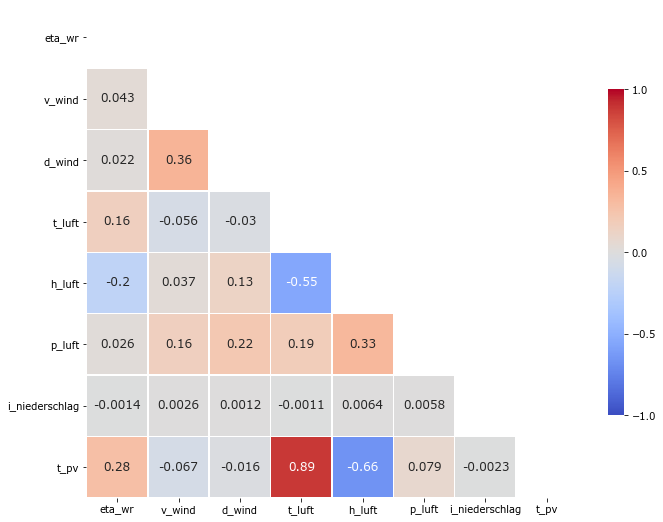

In [8]:
# Plot
f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                  'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})#add the column names as labels

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Select eta all WR

In [9]:
# Database select (SQL)
# all wr eta

sql = text("""
    SELECT  timestamp, wr1_eta_wr, wr2_eta_wr, wr3_eta_wr, wr4_eta_wr, wr5_eta_wr,
    v_wind, d_wind, t_luft, h_luft, p_luft, i_niederschlag   -- column
    FROM    pv3.pv3_time_sun_weather_allwr_2015_mview  -- table
    """)
df_etaAllWr = pd.read_sql_query(sql, con)
df_etaAllWr = df_etaAllWr.set_index('timestamp')
#df_etaAllWr.head()

In [10]:
# Nur Rows, bei denen eta_wr nicht NaN oder <= 0 ist
df_etaAllWr_NoNaN_NoNull = df_etaAllWr.dropna(subset=['wr1_eta_wr', 'wr2_eta_wr',
                                                     'wr3_eta_wr', 'wr4_eta_wr',
                                                     'wr5_eta_wr'])
df_etaAllWr_NoNaN_NoNull = df_etaAllWr_NoNaN_NoNull.loc[(df_etaAllWr_NoNaN_NoNull.wr1_eta_wr > 0) &
                                                        (df_etaAllWr_NoNaN_NoNull.wr2_eta_wr > 0) &
                                                        (df_etaAllWr_NoNaN_NoNull.wr3_eta_wr > 0) &
                                                        (df_etaAllWr_NoNaN_NoNull.wr4_eta_wr > 0) &
                                                        (df_etaAllWr_NoNaN_NoNull.wr5_eta_wr > 0)]
#df_etaAllWr_NoNaN_NoNull.head()

In [11]:
corr_matrix = df_etaAllWr_NoNaN_NoNull.corr()
corr_matrix_clean = corr_matrix[:5].drop(corr_matrix.columns[:5], axis=1)
corr_matrix_clean

,v_wind,d_wind,t_luft,h_luft,p_luft,i_niederschlag
wr1_eta_wr,0.017151,0.008429,0.209433,-0.244682,0.027470,-0.001271
wr2_eta_wr,0.019029,-0.001934,0.259911,-0.279319,0.037056,-0.000697
wr3_eta_wr,0.027755,0.013947,0.211915,-0.301611,0.032876,-0.001013
wr4_eta_wr,0.024260,0.006283,0.353435,-0.410766,0.045195,-0.003648
wr5_eta_wr,-0.005277,-0.005559,0.242094,-0.262407,0.060487,-0.005635


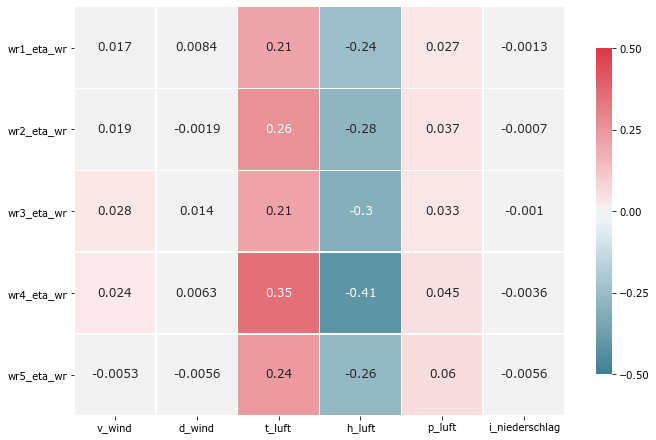

In [12]:
# Plot
f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(corr_matrix_clean,
#                      mask = mask,
                      square = True,
                      linewidths = .5,
                      #cmap = 'coolwarm',
                      cmap=sns.diverging_palette(220, 10, as_cmap=True),
                      cbar_kws = {'shrink': .4, 
                                  'ticks' : [-.5, -.25, 0, 0.25, .5]},
                      vmin = -0.5,
                      vmax = 0.5,
                      annot = True,
                      annot_kws = {'size': 12})#add the column names as labels

ax.set_yticklabels(corr_matrix_clean.index, rotation = 0)
ax.set_xticklabels(corr_matrix_clean.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [13]:
heatmap.get_figure().savefig('heatmap.svg', bbox_inches='tight', dpi=300)

## Select eta p_ac all WR

In [14]:
# Database select (SQL)
sql = text("""
    SELECT  timestamp, wr1_p_ac, wr2_p_ac, wr3_p_ac, wr4_p_ac, wr5_p_ac,
    wr1_eta_wr, wr2_eta_wr, wr3_eta_wr, wr4_eta_wr, wr5_eta_wr -- column
    FROM    pv3.pv3_time_sun_weather_allwr_2015_mview  -- table
    """)
df_etaP = pd.read_sql_query(sql, con)
df_etaP = df_etaP.set_index('timestamp')
df_etaP_filled = df_etaP.fillna(0)
df_etaP_filled.head()

,wr1_p_ac,wr2_p_ac,wr3_p_ac,wr4_p_ac,wr5_p_ac,wr1_eta_wr,wr2_eta_wr,wr3_eta_wr,wr4_eta_wr,wr5_eta_wr
timestamp,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_reH = df_etaP_filled.resample('1H').mean()

In [15]:
def density_scatter(x, y, ax, sort = True, bins = 20, **kwargs):
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None:
        fig, ax = plt.subplots()
    data, x_e, y_e = np.histogram2d(x, y, bins = bins, density = True)
    z = interpn(( 0.5*(x_e[1:] + x_e[:-1]), 0.5*(y_e[1:]+y_e[:-1])),
                data, np.vstack([x,y]).T, method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)

    #norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    #cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    #cbar.ax.set_ylabel('Density')

    return ax

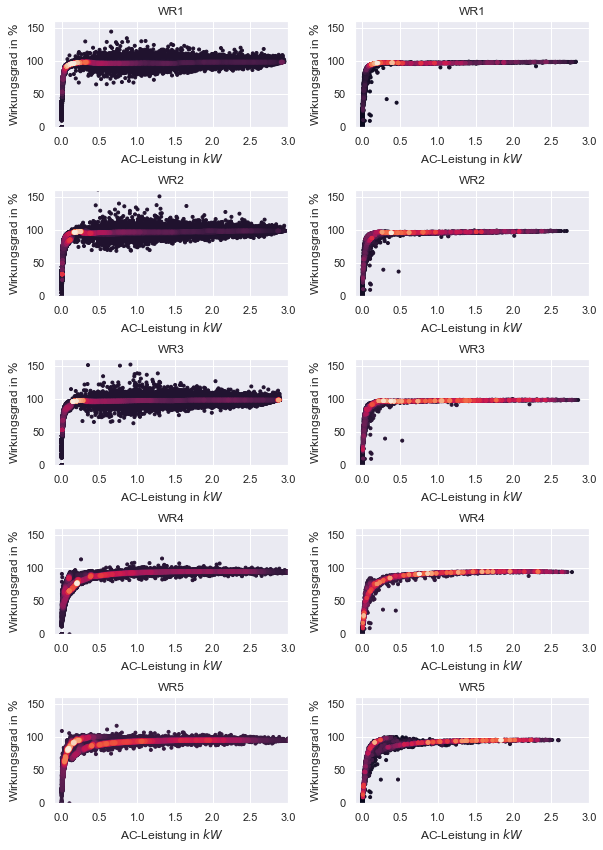

In [31]:
fig, axs = plt.subplots(5,2, figsize=(8.27, 11.69), constrained_layout=True)
#fig.subplots_adjust(hspace = .5, wspace=.001)

#axs = axs.ravel()

sns.set()

for i in range(5):
    density_scatter(df_etaP_filled.iloc[:,i].multiply(1/1000), df_etaP_filled.iloc[:,i+5].multiply(100),
                    axs[i,0], bins = [200,200], marker=".")
    axs[i,0].set_ylim(0, 160)
    axs[i,0].set_xlim(-0.1, 3)
    axs[i,0].set_title('WR{}'.format(i+1))
    axs[i,0].set_ylabel(r'Wirkungsgrad in $\%$')
    axs[i,0].set_xlabel(r'AC-Leistung in $kW$')
    
    density_scatter(df_reH.iloc[:,i].multiply(1/1000), df_reH.iloc[:,i+5].multiply(100),
                    axs[i,1], bins = [200,200], marker=".")
    axs[i,1].set_ylim(0, 160)
    axs[i,1].set_xlim(-0.1, 3)
    axs[i,1].set_title('WR{}'.format(i+1))
    axs[i,1].set_ylabel(r'Wirkungsgrad in $\%$')
    axs[i,1].set_xlabel(r'AC-Leistung in $kW$')

#fig.delaxes(axs[5])

#fig.savefig('density_scatter_allWR.png', format='png', bbox_inches='tight', dpi=300)

In [32]:
fig.savefig('density_scatter_allWR.png', format='png', bbox_inches='tight', dpi=600)

## Select all WR

Requires script: htw_pv3_postgresql_06_data_join.sql

In [ ]:
# Database select (SQL)
sql = text("""
    SELECT  timestamp, g_gen_cmp11, wr1_p_ac, wr2_p_ac, wr3_p_ac, wr4_p_ac, wr5_p_ac   -- column
    FROM    pv3.pv3_time_sun_weather_allwr_2015_mview  -- table
    """)
df = pd.read_sql_query(sql, con)
df = df.set_index('timestamp')

### Netzeinspeisung bestimmen

In [ ]:
df.iloc[600:605, :]

In [ ]:
df.wr1_p_ac.sum() / (1000 * 60)

In [ ]:
df_FeedIn = df.groupby([lambda x: x.year, lambda x: x.month]).sum().multiply(1/(60 * 1000))

In [ ]:
df_FeedIn.to_excel(r'C:\Users\kilia\Documents\HTW\HTW_M_2_Semester\PV3\2007_A11\Messdaten\2020-07-10_FeedIn.xlsx')

### Plot all WR (takes a minute)

In [ ]:
ax = df.plot(figsize=(12, 4), lw=0.25)

### Resample to 1 hour

In [ ]:
df_reH = df.resample('1H').mean()
ax = df_reH.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 day

In [ ]:
df_reD = df.resample('1D').mean()
ax = df_reD.plot(figsize=(12, 4), lw=0.75)

### Resample to 1 month

In [ ]:
df_reM = df.resample('1M').mean()
ax = df_reM.plot(figsize=(12, 4), lw=0.75)

### Bar plot per month

In [ ]:
df_reM = df.resample('1M').mean()
ax = df_reM.plot.bar(figsize=(12, 4), stacked=False, colormap='viridis')

# Metadata

The important information from the above select (**df**) is collected in a Dictionary (**info_dict**).

In [ ]:
# Facts dict
info_dict = {}
info_dict['Filename'] = ['{}_pv3_sonnja_plot_all_wr'.format(pd.to_datetime('today').strftime("%Y-%m-%d"))]
info_dict['Value'] = ['Leistung (P_AC)']
info_dict['Unit'] = ['W']
info_dict['Y-Axis'] = ['{} in {}'.format(*info_dict['Value'], *info_dict['Unit'])]
info_dict['X-Axis'] = ['Stunde im Jahr']
info_dict['Title'] = ['Alle Wechselrichter']
info_dict['Metadata'] = [meta_str]

# Print facts
# for x in info_dict:
#     print(x,':',info_dict[x])

## Plot with Metadata

In [ ]:
sns.set_palette("husl")
mfig = plt.figure(figsize=(12, 5))
ax = plt.subplot()
plt.title(*info_dict['Title'], fontsize=16)         # Title from info
plt.ylabel(*info_dict['Y-Axis'])                    # Label from info
df.resample('1H').mean().plot(ax=ax, lw=0.5, markeredgewidth=3)
ax.set_ylim(ymin=0)

## Interactive Plot with Metadata

In [ ]:
# Interactive plot
data = [
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr1_p_ac'].tolist(), 
               name='WR1', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr2_p_ac'].tolist(), 
               name='WR2', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr3_p_ac'].tolist(), 
               name='WR3', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr4_p_ac'].tolist(), 
               name='WR4', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['wr5_p_ac'].tolist(), 
               name='WR5', line=dict(), mode='lines'),
    go.Scatter(x=df_reD.index.tolist(), 
               y=df_reD['g_gen_cmp11'].tolist(), 
               name='CMP11', line=dict(), mode='lines'),
]
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
fig = go.Figure(data=data, layout=layout)
pltly.iplot(fig)

### One WR

In [ ]:
# Interactive plot
sns.set_style('ticks')
trace_line = go.Scatter(x=df_reD.index.tolist(), 
                        y=df_reD['wr1_p_ac'].tolist(), 
                        name='WR1 täglich', line=dict(), mode='lines')
trace_bar = go.Bar(x=df_reM.index.tolist(), 
                   y=df_reM['wr1_p_ac'].tolist(), 
                   name='WR1 monatlich', marker=dict())
layout = go.Layout(
    title=''.join(info_dict['Title']),
    yaxis=dict(title=''.join(info_dict['Y-Axis'])),
    xaxis=dict(title=''.join(info_dict['X-Axis']))
)
ifig = go.Figure(data=[trace_bar, trace_line], layout=layout)
pltly.iplot(ifig)

## Save results to files

The results are saved to cooresponding files in a folder named **data**.<br>
The **info_dict** is saved to a text file (txt).<br>
The **data** is saved to a table (csv).<br>
The **plot** is saved as an image (png).<br>
The **interactive plot** is saved as a webpage (html). It will also open in a new tab of your browser.

In [ ]:
# Write facts to textfile
txtname = ('data/{}.txt').format(*info_dict['Filename'])
with open(txtname,'w') as tfile:
    for i in info_dict.keys():
        tfile.write(i + ": " + ', '.join([str(x) for x in info_dict[i]]) + "\n")
tfile.close()
print("Facts saved to file:", txtname)

# Save data to CSV
csvname = 'data/{}.csv' .format(*info_dict['Filename'])
df_reH.to_csv(csvname, sep=';')
print("Data saved to file:", csvname)

# Save plot as file
plotname = 'data/{}.png' .format(*info_dict['Filename'])
mfig.savefig(plotname, bbox_inches='tight')
print("Plot saved to file:", plotname)

# Save interactive plot
htmlname = 'data/{}.html' .format(*info_dict['Filename'])
pltly.plot(ifig, filename=htmlname)
print("Interactive plot saved to file:", htmlname)